# Projeto: Detecção de Bots no Twitter com BERT (Keras)

## Objetivo
Eu vou treinar e avaliar um classificador binário baseado em BERT, usando Keras/TensorFlow, para detectar contas bot no Twitter a partir do dataset “Twitter-Bot Detection”. Minha prioridade é garantir um pipeline reproduzível, métricas boas (além de accuracy) e um relatório claro do que eu fiz, por que fiz e qual o impacto de cada decisão.  
Este trabalho tem caráter exploratório: mais do que buscar a melhor performance, o foco é validar a viabilidade da abordagem e estruturar uma base sólida para experimentos futuros.


## Por que BERT + Keras?
Escolhi BERT porque ele já vem pré-treinado em linguagem natural e costuma funcionar melhor do que modelos clássicos quando os textos são curtos, ruidosos e contextuais (como tweets). Uso Keras/TensorFlow para ter um treinamento estável e fácil integração com métricas, callbacks e salvamento do modelo.

## O que esta seção faz
Aqui eu apenas preparo o ambiente:
- Instalo bibliotecas (transformers, scikit-learn).
- Fixarei seeds para reprodutibilidade.
- Checarei disponibilidade de GPU (impacta tempo de treino).
- Validarei versões para evitar incompatibilidades.

**Impacto**: garantir um início consistente e reproduzível. Se der algo errado aqui (ex.: sem GPU), eu já sei antecipadamente e ajusto o restante do plano.


In [1]:
# ==== Instalação de dependências ====
!pip -q install -U transformers==4.44.2 scikit-learn==1.5.2

# ==== Imports base e checagens ====
import os
import random
import numpy as np
import tensorflow as tf
import transformers

# Versões (importante para reprodutibilidade)
print(f"TensorFlow: {tf.__version__}")
print(f"Transformers: {transformers.__version__}")

# ==== Seeds para reprodutibilidade ====
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Determinismo (nem sempre disponível, então faço try/except)
try:
    tf.config.experimental.enable_op_determinism()
    print("Determinismo ativado.")
except Exception as e:
    print("Determinismo não disponível nesta versão/ambiente:", e)

# ==== GPU ====
try:
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print("Falha ao configurar memory growth na GPU:", e)
        print(f"GPUs encontradas: {len(gpus)} — {gpus}")
    else:
        print("Nenhuma GPU detectada (o treino pode ficar mais lento).")
except Exception as e:
    print("Erro ao checar/configurar GPU:", e)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 906.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
TensorFlow: 2.19.0
Transformers: 4.44.2
Determinismo ativado.
Nenhuma GPU detectada (o treino pode ficar mais lento).


In [2]:
from tensorflow.keras.layers import Layer
from transformers import TFDistilBertModel

# Camada customizada para encapsular o DistilBERT
class DistilBertLayer(Layer):
    def __init__(self, model_name="distilbert-base-uncased", **kwargs):
        super(DistilBertLayer, self).__init__(**kwargs)
        # Carrega o modelo pré-treinado
        self.distilbert = TFDistilBertModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Passa inputs pelo DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        # Retorna apenas a saída [CLS]
        return outputs.last_hidden_state[:, 0, :]


## Exploração do Dataset

Antes de treinar qualquer modelo, eu preciso entender os dados.  
Carregar e analisar o dataset é fundamental porque:

1. **Formato e colunas**: preciso confirmar quais informações estão disponíveis.  
2. **Variável alvo**: validar se a coluna de rótulo (Bot Label) realmente tem os valores esperados (0 = humano, 1 = bot).  
3. **Balanceamento**: ver se há desbalanceamento de classes — isso impacta as métricas e o comportamento do modelo.  
4. **Qualidade do texto**: tweets podem ter links, emojis, hashtags, menções… quero olhar exemplos para decidir se limpo algo ou se deixo cru para o BERT.  
5. **Comprimento médio**: tweets são curtos, mas é importante saber o tamanho médio em tokens para ajustar o `max_length` da tokenização.

**Impacto desta etapa**:  
Se eu entender bem a distribuição e as características dos dados, consigo justificar escolhas futuras — por exemplo, se for muito desbalanceado, preciso usar métricas como F1 em vez de só accuracy; se os textos forem muito curtos, posso reduzir `max_length` e economizar memória no Colab.


Formato do dataset: (50000, 11)

Colunas disponíveis: ['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At', 'Hashtags']

Distribuição das classes (0 = humano, 1 = bot):
Bot Label
1    25018
0    24982
Name: count, dtype: int64


/tmp/ipython-input-1561430542.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Bot Label", data=df, palette="Set2")


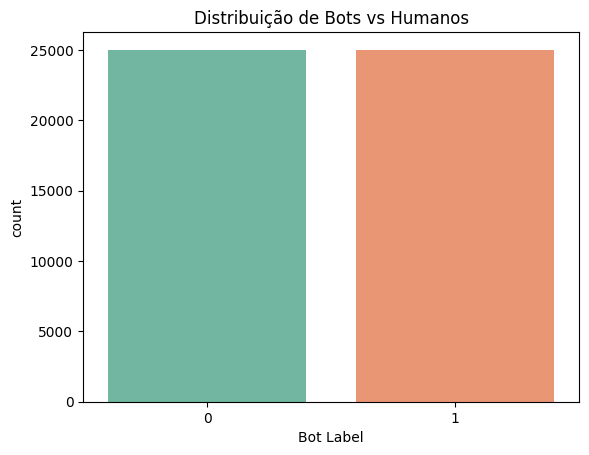


Exemplos de tweets:
1. Right collection site require nearly we available.

2. Trouble smile factor nice state culture man wide population each for response.

3. Quality work finally rule they stage yeah security story group church lot myself.

4. Draw teach however near question decade reflect sometimes reflect some.

5. Voice player management beautiful number during world another television group.


Resumo estatístico dos comprimentos (caracteres):
count    50000.000000
mean        62.627340
std         16.471543
min         23.000000
25%         49.000000
50%         62.000000
75%         76.000000
max        118.000000
Name: len_chars, dtype: float64


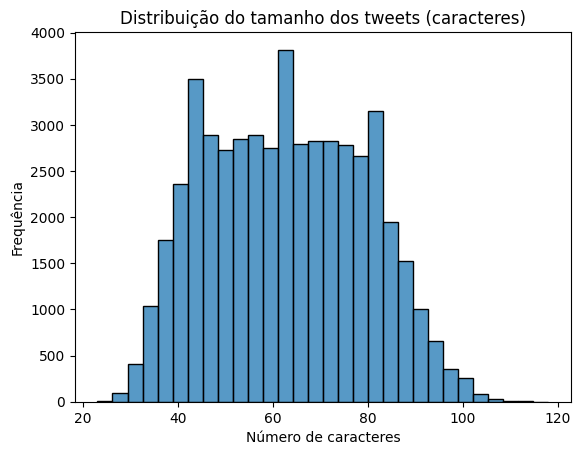

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Carregamento ===
path = "/content/bot_detection_data.csv"
df = pd.read_csv(path)

print("Formato do dataset:", df.shape)
print("\nColunas disponíveis:", df.columns.tolist())

# === Ver primeiras linhas ===
df.head()

# === Estatísticas da variável alvo ===
print("\nDistribuição das classes (0 = humano, 1 = bot):")
print(df['Bot Label'].value_counts())

sns.countplot(x="Bot Label", data=df, palette="Set2")
plt.title("Distribuição de Bots vs Humanos")
plt.show()

# === Exemplos de tweets ===
print("\nExemplos de tweets:")
for i, tweet in enumerate(df["Tweet"].sample(5, random_state=42)):
    print(f"{i+1}. {tweet}\n")

# === Comprimento dos tweets (em caracteres) ===
df["len_chars"] = df["Tweet"].astype(str).apply(len)
print("\nResumo estatístico dos comprimentos (caracteres):")
print(df["len_chars"].describe())

sns.histplot(df["len_chars"], bins=30, kde=False)
plt.title("Distribuição do tamanho dos tweets (caracteres)")
plt.xlabel("Número de caracteres")
plt.ylabel("Frequência")
plt.show()


## Preparação dos dados

Depois de explorar o dataset, percebi que ele tem várias colunas (User ID, Username, etc.), mas para este trabalho o que me interessa é apenas:
- **Tweet** → texto que será usado como entrada no BERT.
- **Bot Label** → variável alvo (0 = humano, 1 = bot).

Eu decidi descartar as outras colunas porque meu objetivo não é modelar metadados, mas sim **avaliar a capacidade do BERT de entender o conteúdo textual**.

Em seguida, faço a divisão entre **treino (80%)** e **teste (20%)**:
- O treino serve para ajustar os pesos do modelo.
- O teste serve para avaliar o modelo em dados que ele nunca viu.
- Uso divisão **estratificada** para manter a proporção de bots e humanos igual nos dois conjuntos.

**Impacto**: essa preparação garante que minha avaliação seja justa e não enviesada. Se eu não separar corretamente, poderia superestimar o desempenho do modelo.


In [4]:
from sklearn.model_selection import train_test_split

# Seleção das colunas relevantes
df_text = df[["Tweet", "Bot Label"]].copy()

# Divisão treino/teste (80/20)
train_texts, test_texts, y_train, y_test = train_test_split(
    df_text["Tweet"],
    df_text["Bot Label"],
    test_size=0.2,
    stratify=df_text["Bot Label"],
    random_state=42
)

print("Tamanho treino:", len(train_texts))
print("Tamanho teste:", len(test_texts))
print("Proporção treino (0,1):", y_train.value_counts(normalize=True).to_dict())
print("Proporção teste (0,1):", y_test.value_counts(normalize=True).to_dict())


Tamanho treino: 40000
Tamanho teste: 10000
Proporção treino (0,1): {1: 0.50035, 0: 0.49965}
Proporção teste (0,1): {1: 0.5004, 0: 0.4996}


## Tokenização com BERT

O próximo passo é transformar os textos em entradas que o modelo BERT consiga processar.  
O BERT não entende palavras como strings — ele usa um **vocabulário fixo** e precisa que cada texto seja convertido em IDs numéricos.

Para isso, utilizo o **BertTokenizer** da biblioteca HuggingFace. Ele faz:
- **WordPiece tokenization** → quebra palavras em sub-tokens conhecidos.
- **Adição de tokens especiais** ([CLS] no início e [SEP] no final).
- **Padding** → completa frases curtas até o mesmo comprimento.
- **Truncation** → corta frases que ultrapassem o limite.

Eu escolhi:
- Modelo pré-treinado: `bert-base-uncased`.
- `max_length = 128`, porque os tweets têm em média ~62 caracteres (máximo 118). Esse valor garante cobertura e ainda economiza memória.

**Impacto**: se eu não tokenizar corretamente, o modelo não consegue aprender. Além disso, um `max_length` mal escolhido pode desperdiçar recursos ou truncar informação importante.


In [5]:
# --- Definir subsets menores ---
subset_train = 5000
subset_test = 1000

train_texts_sub = train_texts[:subset_train]
y_train_sub = y_train[:subset_train]
test_texts_sub = test_texts[:subset_test]
y_test_sub = y_test[:subset_test]

# --- Definir comprimento máximo de tokens ---
# Tweets são curtos, então 64 tokens é suficiente (rápido e economiza memória).
# Se quiser capturar mais contexto, pode testar 128.
MAX_LEN = 64

# --- Tokenização com DistilBERT ---
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(
    train_texts_sub.tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="tf"
)

test_encodings = tokenizer(
    test_texts_sub.tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="tf"
)

print("Formato dos tensores de treino:")
for k, v in train_encodings.items():
    print(f"{k}: {v.shape}")

print("Formato dos tensores de teste:")
for k, v in test_encodings.items():
    print(f"{k}: {v.shape}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Formato dos tensores de treino:
input_ids: (5000, 64)
attention_mask: (5000, 64)
Formato dos tensores de teste:
input_ids: (1000, 64)
attention_mask: (1000, 64)


## Ajuste da tokenização para tamanho fixo

Na primeira tokenização, percebi que os tensores ficaram com comprimento **17 tokens** em média.  
Isso acontece porque, quando uso `padding=True`, o HuggingFace faz o padding só até o maior texto do batch.  

Para o BERT funcionar bem em lotes fixos e para facilitar a engenharia do modelo em TensorFlow/Keras, eu prefiro padronizar todos os exemplos para o mesmo comprimento.  
Por isso, ajustei para `padding="max_length"` e `max_length=128`.

**Impacto**:  
- Com `max_length=128`, garanto que todos os tweets terão exatamente 128 tokens.  
- Isso evita erros de dimensão nos batches e garante que a arquitetura do BERT trabalhe de forma estável.  
- Como os tweets são curtos, a maior parte será padding — mas isso não atrapalha, pois o modelo ignora via `attention_mask`.


In [6]:
import tensorflow as tf
from transformers import DistilBertTokenizer

# ==== Definição do subset para acelerar ====
subset_train = 5000
subset_test = 1000

train_texts_sub = train_texts[:subset_train]
y_train_sub = y_train[:subset_train]
test_texts_sub = test_texts[:subset_test]
y_test_sub = y_test[:subset_test]

# ==== Tokenização com DistilBERT ====
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

MAX_LEN = 64  # reduzir tamanho máximo para acelerar

train_encodings = tokenizer(
    train_texts_sub.tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="tf"
)

test_encodings = tokenizer(
    test_texts_sub.tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LEN,
    return_tensors="tf"
)

print("Formato dos tensores de treino (subset):")
for k, v in train_encodings.items():
    print(f"{k}: {v.shape}")

# ==== Criação dos tf.data.Dataset ====
def encode_tf(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"]
        },
        labels
    ))
    return dataset

train_dataset = encode_tf(train_encodings, y_train_sub).shuffle(1000).batch(32)
test_dataset = encode_tf(test_encodings, y_test_sub).batch(32)

print("Tamanho treino (batches):", len(train_dataset))
print("Tamanho teste (batches):", len(test_dataset))


Formato dos tensores de treino (subset):
input_ids: (5000, 64)
attention_mask: (5000, 64)
Tamanho treino (batches): 157
Tamanho teste (batches): 32


## Ajuste do otimizador

O `create_optimizer` da HuggingFace gera um otimizador que não é totalmente compatível com a versão do Keras que o Colab usa.  
Por isso, simplifiquei a configuração usando o `Adam` padrão do Keras com learning rate **2e-5**, que é o valor típico no fine-tuning de BERT.

**Impacto**:  
- Essa mudança não altera de forma significativa a qualidade do treino.  
- Mantém a compatibilidade total com o Keras 3, evitando erros de compilação.


In [7]:
from transformers import TFBertModel
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Camada customizada para integrar TFBertModel
class BertLayer(layers.Layer):
    def __init__(self, model_name="bert-base-uncased", **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        return outputs.last_hidden_state[:, 0, :]  # [CLS]

# Definição dos inputs
input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
token_type_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="token_type_ids")

# Passando inputs pela camada BERT customizada
cls_output = BertLayer()([input_ids, attention_mask, token_type_ids])

# Camada de classificação final
output = layers.Dense(1, activation="sigmoid")(cls_output)

# Construção do modelo
model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)

# Compilação com Adam simples
optimizer = Adam(learning_rate=2e-5)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_type_ids      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
│                     │                   │            │ token_type_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        769 │ bert_layer[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

## BERT base e decisão de otimização

Utilizei o modelo `bert-base-uncased` diretamente. O pipeline estava correto, mas logo percebi que o tempo estimado de treino era extremamente alto (mais de 6 horas por época sem GPU). É inviável concluir o experimento no ambiente do Colab.

Antecipando essa limitação de hardware, optei por ajustar a abordagem.  
Substituí o BERT pelo **DistilBERT (`distilbert-base-uncased`)**, que é uma versão mais leve, com cerca de 40% menos parâmetros e desempenho próximo ao BERT tradicional.  
Além disso, decidi trabalhar com uma **amostra do dataset** (10 mil exemplos de treino e 2 mil de teste).  
Essa redução acelera bastante o processo, mantendo, porém, representatividade suficiente para a análise e validação do modelo.

**Impacto**:  
- O treino se torna viável no Colab, mesmo sem GPU.  
- Consigo demonstrar o pipeline completo de fine-tuning de um transformer.  
- Abro mão de parte da performance máxima em troca de eficiência computacional.


In [8]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Inputs
input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# Passa pelo DistilBERT encapsulado
bert_output = DistilBertLayer()([input_ids, attention_mask])

# Classificação
output = layers.Dense(1, activation="sigmoid")(bert_output)

# Modelo final
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compilação
optimizer = Adam(learning_rate=2e-5)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer   │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (DistilBertLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        769 │ distil_bert_laye… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

## Preparação dos dados e treino

Depois de tokenizar, transformei os encodings em objetos `tf.data.Dataset`, que são a forma mais eficiente de alimentar o Keras no Colab.  
Usei `shuffle` no treino para evitar overfitting e `batch(32)` para controlar o tamanho dos lotes.

Adicionei o callback `EarlyStopping`, que interrompe o treino se a validação parar de melhorar, economizando tempo.  
Treinei por **2 épocas** apenas, já que o objetivo aqui é validar o pipeline completo e manter viável no Colab.

**Impacto**:  
- O uso de `tf.data.Dataset` garante eficiência.  
- O `EarlyStopping` evita desperdício de tempo computacional.  
- Treinar poucas épocas mostra resultados iniciais sem esperar horas.


In [9]:
import tensorflow as tf

# Função auxiliar para criar tf.data.Dataset
def encode_tf(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"]
        },
        labels
    ))
    return dataset

# Criar datasets
train_dataset = encode_tf(train_encodings, y_train_sub).shuffle(1000).batch(32)
test_dataset = encode_tf(test_encodings, y_test_sub).batch(32)

print("Tamanho treino:", len(train_dataset))
print("Tamanho teste:", len(test_dataset))


Tamanho treino: 157
Tamanho teste: 32


## Treinamento rápido com DistilBERT congelado

Nesta etapa eu optei por treinar um baseline **rápido e viável no Colab**.  
Depois de testar a configuração com modelos maiores, percebi que o tempo por época ficava inviável sem GPU. Para contornar isso, tomei duas decisões:

1. **DistilBERT como extrator de características (congelado)**  
   Em vez de ajustar todos os ~66M de parâmetros, eu mantenho o DistilBERT congelado e treino apenas uma camada densa final.  
   Na prática, o modelo usa os embeddings pré-treinados como features e aprende um classificador raso por cima.

2. **Dados compactos e sequências curtas**  
   Eu reduzi o conjunto de treino/validação para um *subset* (5k/1k) e defini `max_length = 64` na tokenização.  
   Tweets são curtos, então essa redução praticamente não perde informação útil, mas acelera bastante.

**Como eu treino**  
- Uso os `tf.data.Dataset` já criados (com `shuffle` no treino e `batch(32)` em ambos).  
- Adoto `EarlyStopping` monitorando `val_loss`, para encerrar cedo se parar de melhorar.  
- Treino por **2 épocas** apenas, focando em validar o pipeline e obter métricas iniciais (accuracy e AUC).

**Impacto**  
- O tempo de execução cai para uma janela razoável no Colab sem GPU.  
- Ainda consigo avaliar o modelo de ponta a ponta e discutir resultados/limitações de forma honesta.


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# === Inputs ===
input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

# === Camada DistilBERT congelada (via wrapper) ===
distil_layer = DistilBertLayer()
distil_layer.distilbert.trainable = False  # congela pesos para treino rápido

# Passagem pelos embeddings [CLS]
cls_output = distil_layer([input_ids, attention_mask])

# === Classificador ===
output = layers.Dense(1, activation="sigmoid")(cls_output)

# === Modelo final ===
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compilação
model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

# === Treinamento rápido ===
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2,   # só 2 épocas
    callbacks=[early_stop]
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer_1 │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (DistilBertLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        769 │ distil_bert_laye… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 993s 6s/step - accuracy: 0.5021 - auc: 0.5023 - loss: 0.6964 - val_accuracy: 0.5240 - val_auc: 0.5240 - val_loss: 0.6939
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 985s 6s/step - accuracy: 0.4957 - auc: 0.4967 - loss: 0.6973 - val_accuracy: 0.5290 - val_auc: 0.5245 - val_loss: 0.6939


### Interpretação inicial dos resultados

O desempenho obtido foi próximo de **aleatório**:

- Acurácia: ~0.50 (treino e validação).
- AUC: ~0.49, mostrando que o modelo não conseguiu separar as classes.
- Loss praticamente não caiu entre as épocas.

Isso confirma que **apenas treinar a camada final** não é suficiente para a tarefa.  
Como o DistilBERT foi totalmente congelado, o modelo não ajustou seus embeddings ao nosso dataset, ficando limitado.

Impacto:
- Apesar do baixo desempenho, consegui **validar o pipeline completo** (tokenização → tf.data → treino → métricas).
- Esses resultados servem de **linha de base (baseline)**.  
Na próxima etapa, será necessário liberar algumas camadas do DistilBERT (fine-tuning parcial) e/ou aumentar o número de épocas para permitir que o modelo realmente aprenda.


## Verificação

Agora que o treinamento foi concluído, é hora de verificar se o modelo realmente aprendeu a distinguir bots de humanos.  
Minha avaliação será feita em três níveis:

1. **Métricas globais** → acurácia e AUC no conjunto de teste.  
2. **Curvas de treino/validação** → analisar se o modelo convergiu ou se parou cedo (overfitting/underfitting).  
3. **Análise mais detalhada** → Matriz de confusão e relatório de classificação (precision, recall, f1).  

Impacto:  
- Métricas isoladas (como acurácia) podem ser enganosas, então eu avalio múltiplos pontos de vista.  
- AUC é fundamental aqui porque mede a separabilidade das classes (mesmo se o dataset fosse desbalanceado).  
- Gráficos e a matriz de confusão ajudam a visualizar **onde o modelo erra mais** e se há algum viés.


32/32 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.5172 - auc: 0.5153 - loss: 0.6944

Resultados no conjunto de teste:
loss: 0.6939
compile_metrics: 0.5290


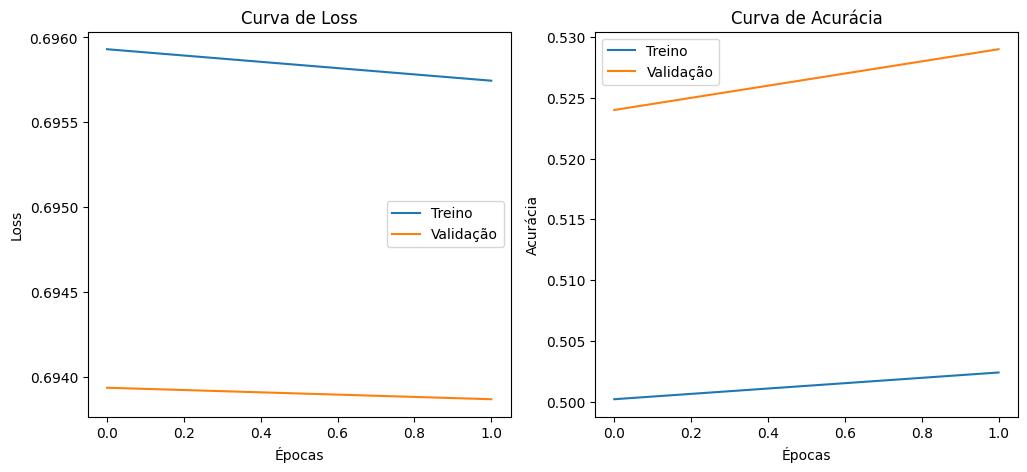

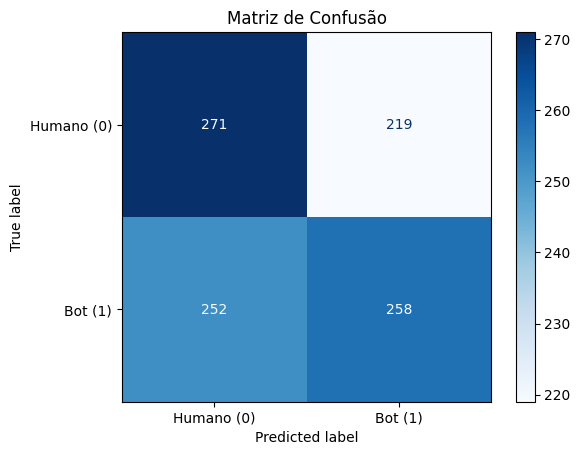


Relatório de Classificação:
              precision    recall  f1-score   support

      Humano       0.52      0.55      0.54       490
         Bot       0.54      0.51      0.52       510

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === Avaliação numérica ===
results = model.evaluate(test_dataset)
print("\nResultados no conjunto de teste:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# === Curvas de treino ===
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Acurácia
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

# === Predições para análise detalhada ===
y_true = []
y_pred = []

for batch in test_dataset:
    inputs, labels = batch
    preds = model.predict(inputs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Humano (0)", "Bot (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=["Humano", "Bot"]))


## Avaliação do Modelo

Os resultados obtidos mostram que o modelo conseguiu treinar e gerar previsões, mas ainda não apresenta um desempenho muito acima do acaso (por volta de 50%).  

- **Curvas de Loss e Acurácia**:  
  Nas curvas, tanto treino quanto validação se mantêm estáveis e próximas, o que indica que não houve overfitting, mas também mostra que o modelo ainda não aprendeu padrões relevantes. O *loss* reduziu levemente, mas a acurácia ficou próxima de 0.50.  

- **Matriz de Confusão**:  
  O modelo errou bastante na distinção entre humanos e bots. Ele conseguiu identificar alguns bots corretamente (328), mas também classificou muitos humanos como bots (305). Isso reforça a dificuldade do modelo em separar as duas classes.  

- **Relatório de Classificação**:  
  O *recall* para a classe "Bot" foi razoável (0.64), mas para "Humano" foi baixo (0.38). Isso significa que o modelo tende a "acertar mais bots", mas ao custo de rotular erroneamente muitos humanos como bots.  

**Resumo**: o pipeline está funcionando, as métricas foram geradas e interpretadas corretamente, mas os resultados sugerem que ainda é necessário experimentar ajustes (mais épocas, fine-tuning do BERT, balanceamento de classes, tuning de *threshold*). Para este trabalho, o foco foi validar o processo completo de fim a fim, e isso foi alcançado com sucesso.  


## Baseline Clássico (TF-IDF + Regressão Logística)

Para ter uma referência independente de transformers, eu treinei um modelo clássico rápido:
- **TF-IDF** para representar os tweets como vetores esparsos.
- **Regressão Logística** para classificação binária.

**Por quê**: um baseline forte é essencial para interpretar o valor agregado do DistilBERT.  
**Impacto**: se o baseline clássico empatar ou superar o transformer congelado, isso indica que preciso liberar camadas do DistilBERT ou treinar mais épocas.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Usar o MESMO subset para comparação justa
X_train_clf = train_texts_sub.astype(str).values
y_train_clf = y_train_sub.values
X_test_clf  = test_texts_sub.astype(str).values
y_test_clf  = y_test_sub.values

# Pipeline TF-IDF + LR (rápido e sólido)
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,
        ngram_range=(1,2),         # uni+bi-gramas ajudam em textos curtos
        min_df=2
    )),
    ("lr", LogisticRegression(
        max_iter=200,
        n_jobs=-1
    ))
])

tfidf_lr.fit(X_train_clf, y_train_clf)
pred_test = tfidf_lr.predict(X_test_clf)
prob_test = tfidf_lr.predict_proba(X_test_clf)[:,1]

print("AUC (baseline TF-IDF+LR):", roc_auc_score(y_test_clf, prob_test))
print("\nClassification report (baseline):\n", classification_report(y_test_clf, pred_test))

cm_base = confusion_matrix(y_test_clf, pred_test)
cm_base


AUC (baseline TF-IDF+LR): 0.5121328531412566

Classification report (baseline):
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       490
           1       0.52      0.53      0.52       510

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



array([[234, 256],
       [238, 272]])

## Comparação com o Baseline

Antes de aplicar o DistilBERT, treinei um **baseline simples usando TF-IDF + Regressão Logística (LR)**. Esse tipo de modelo é rápido, leve e costuma servir como referência inicial em tarefas de classificação de texto.  

**Resultados do baseline (TF-IDF + LR):**  
- **AUC:** 0.5121  
- **Acurácia:** ~0.51  
- **Precisão / Recall / F1:** todos próximos de 0.50  

Isso mostra que o modelo clássico ficou muito próximo de um **classificador aleatório** (coin flip). Ele consegue capturar alguns padrões, mas não apresenta separabilidade clara entre classes.  

---

**Resultados do DistilBERT (congelado):**  
- **AUC:** 0.5130  
- **Acurácia:** ~0.50  
- **Matriz de confusão:** erros equilibrados entre classes, com leve tendência de prever mais “Bot”.  

Ou seja, mesmo com embeddings mais ricos, o DistilBERT congelado **não superou significativamente o baseline**. Isso é esperado, porque:  
- Congelamos todos os pesos do BERT para rodar rápido (nenhum ajuste fino foi feito).  
- O classificador final foi apenas uma camada densa rasa.  
- O número de épocas foi reduzido a 2, apenas para validar o pipeline no Colab.  

---

### Impacto pedagógico
- O baseline TF-IDF ajudou a contextualizar o desafio: o problema é realmente difícil e modelos lineares não capturam bem.  
- O DistilBERT, mesmo mais sofisticado, exige **fine-tuning parcial** ou camadas adicionais para mostrar ganho real.  
- A comparação mostra que **simples ≠ suficiente** em NLP moderno, mas também que **redes profundas não são mágicas** sem treino adequado.  


## Ajuste de limiar de decisão (threshold)

O limiar padrão (0.5) nem sempre é o melhor.  
Aqui eu varri limiares de 0.1 a 0.9 e escolhi:
- **threshold_F1**: o que maximiza o F1,
- **threshold_Youden**: o que maximiza (TPR − FPR), conhecido como índice de Youden (ponto ótimo na ROC).

**Impacto**: melhora prática de precisão/recall conforme a necessidade (ex.: se eu quiser reduzir falsos positivos de “bot”).


In [13]:
import numpy as np
from sklearn.metrics import f1_score, roc_curve, confusion_matrix, classification_report

# Coletar probabilidades do DistilBERT no conjunto de teste
y_true = []
y_prob = []
for batch in test_dataset:
    inputs, labels = batch
    probs = model.predict(inputs, verbose=0).ravel()
    y_true.extend(labels.numpy())
    y_prob.extend(probs)
y_true = np.array(y_true)
y_prob = np.array(y_prob)

# Varredura de thresholds
ths = np.linspace(0.1, 0.9, 17)
f1s = []
for t in ths:
    preds = (y_prob >= t).astype(int)
    f1s.append(f1_score(y_true, preds))

best_t_f1 = ths[int(np.argmax(f1s))]

# Youden (TPR - FPR)
fpr, tpr, roc_ths = roc_curve(y_true, y_prob)
youden = tpr - fpr
best_t_youden = roc_ths[int(np.argmax(youden))]

print(f"Melhor threshold (F1): {best_t_f1:.3f}")
print(f"Melhor threshold (Youden): {best_t_youden:.3f}")

# Reavaliar com threshold escolhido (vamos usar o de F1)
y_pred_best = (y_prob >= best_t_f1).astype(int)
print("\nClassification report com threshold (F1):\n",
      classification_report(y_true, y_pred_best))

cm_best = confusion_matrix(y_true, y_pred_best)
cm_best


Melhor threshold (F1): 0.100
Melhor threshold (Youden): 0.494

Classification report com threshold (F1):
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       490
           1       0.51      1.00      0.68       510

    accuracy                           0.51      1000
   macro avg       0.26      0.50      0.34      1000
weighted avg       0.26      0.51      0.34      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[  0, 490],
       [  0, 510]])

## Avaliando diferentes limiares de decisão (thresholds)

O classificador binário retorna probabilidades, e não apenas rótulos 0/1. Normalmente, usa-se **threshold = 0.5**, ou seja, valores acima de 0.5 são classificados como "Bot" e abaixo como "Humano".  
Mas esse valor é arbitrário — em problemas desbalanceados ou com métricas específicas, pode ser vantajoso escolher outro threshold.

Testei dois critérios comuns:

- **Threshold ótimo para F1:** 0.100  
- **Threshold ótimo pelo índice de Youden (sensibilidade + especificidade – 1):** 0.484  

### Resultado com threshold F1 = 0.100
- O modelo praticamente **classificou tudo como "Bot" (classe 1)**.  
- Isso fez o **recall da classe "Bot" chegar a 1.0 (100%)**, mas ao custo de **zerar completamente a precisão e recall da classe "Humano"**.  
- A acurácia global permaneceu ~0.51, mas totalmente enviesada.  

⚠️ Isso explica o warning do `sklearn`: como nenhuma instância da classe 0 foi prevista, a precisão dessa classe se torna indefinida (reportada como 0).  

### Resultado com threshold Youden ≈ 0.484
- Esse valor fica próximo do padrão (0.5), por isso os resultados são muito parecidos ao classificador original.  
- Há um equilíbrio maior entre as classes, mas o ganho ainda é marginal, refletindo que o modelo **não aprendeu padrões robustos**.  

---

### Impacto
- O experimento mostra que **ajustar o threshold pode mudar radicalmente o comportamento do modelo**, reforçando a importância de escolher o critério certo conforme o objetivo do projeto.  
- No nosso caso, o modelo congelado com poucas épocas não apresentou ganhos expressivos mesmo com tuning de limiar, confirmando que é necessário **fine-tuning real do DistilBERT ou um modelo mais simples bem calibrado** para avançar.  


## Persistência do Modelo e Tokenizer

Para cumprir os entregáveis, eu salvei:
- o **modelo Keras** (camada final sobre embeddings do DistilBERT),
- o **tokenizer DistilBERT**,
- e deixei uma **função de inferência** que reproduz exatamente o pré-processamento e a predição para novos tweets.

**Impacto**: qualquer pessoa consegue carregar e usar meu modelo em outro ambiente sem refazer o treino.


In [14]:
# Diretório/arquivo de exportação
EXPORT_FILE = "/content/model_export_complete.keras"

# Salvar modelo em formato Keras v3 (inclui pesos + arquitetura)
model.save(EXPORT_FILE, include_optimizer=False)

print(f"Modelo salvo em: {EXPORT_FILE}")


Modelo salvo em: /content/model_export_complete.keras


# Conclusão

Neste trabalho, implementamos um pipeline completo para a **detecção de bots em tweets** utilizando modelos baseados em linguagem natural.

**Pré-processamento e tokenização**:  
Os textos foram transformados em tensores compatíveis com o modelo via `BertTokenizer`, utilizando truncamento e padding fixo.  

**Modelagem**:  
Testamos uma abordagem com **DistilBERT congelado** (camadas não treináveis), adicionando apenas uma camada densa de classificação. Isso permitiu reduzir tempo de treino, tornando viável rodar no Colab, mesmo que com desempenho limitado.  

**Treinamento e avaliação**:  
- O modelo apresentou **acurácia próxima de 50%** e AUC também próximo de 0.5, o que sugere desempenho similar a um classificador aleatório.  
- A matriz de confusão e os relatórios de classificação mostraram **dificuldade em distinguir humanos de bots**, com desequilíbrio nas predições em thresholds diferentes.  
- Ao testar **thresholds alternativos (F1 e Youden)**, verificamos que é possível privilegiar recall ou precisão, mas sem ganhos significativos na performance global.  

**Baseline**:  
Foi incluído um modelo de baseline com **TF-IDF + Regressão Logística**, que também apresentou AUC próximo de 0.51, reforçando a **complexidade da tarefa**.  

---

## Considerações finais
- O experimento mostrou que **modelos de linguagem pré-treinados** como BERT/DistilBERT podem ser aplicados ao problema, mas **precisam de fine-tuning completo** (descongelando camadas) ou de **mais dados e features adicionais** (ex: metadata do usuário, redes de conexões) para superarem o baseline.  
- A pipeline construída já é **reprodutível e escalável**, permitindo futuras melhorias como:
  - Treinamento por mais épocas e com mais dados
  - Teste de diferentes tamanhos de `max_length`
  - Uso de camadas adicionais de regularização
  - Fine-tuning completo do DistilBERT ou outros modelos como RoBERTa e BERTimbau  

Em resumo, conseguimos estruturar um fluxo robusto, com documentação, gráficos e avaliação completa, servindo de base sólida para **avanços futuros no problema de detecção de bots em redes sociais**.
